In [1]:
import sys
print(sys.executable)

/home/dministrator-drew/projects/cesi/Data Science Option/.venv-andrew/bin/python


In [2]:
import tensorflow as tf

# TensorFlow version
print("TensorFlow version:", tf.__version__)

# Check available GPUs
gpus = tf.config.list_physical_devices('GPU')
print("GPUs detected:", gpus)

# Optional: enable memory growth
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)


2025-12-18 14:51:32.922390: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-18 14:51:34.657703: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-12-18 14:51:37.964530: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
/home/dministrator-drew/projects/cesi/Data Science Option/.venv-andrew/lib/pytho

TensorFlow version: 2.20.0
GPUs detected: []


W0000 00:00:1766065903.134595    1222 gpu_device.cc:2342] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


This project focuses on the binary classification of an image dataset into classes: __Photo and Non-photo__. The dataset consists of five individual datasets: _Photo, Schematics, Sketch, Text and Painting_. Within this notebook, I shall cover the following steps:

    1. Importing libraries, defining constraints and merging of the classes (sketch, painting, text and schematics) into one photo. Also, deleting corrupted files found.

    2. Separation into train and test sets
    3. Data exploration and visualization
    4. Building the training environment
    5. Training and evaluation
    6. Fine tuning and balancing

__Step 1__

In [2]:
#Importing libraries
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
from tensorflow.keras import layers, Sequential

2025-12-18 12:12:49.372941: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-18 12:12:51.263910: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-12-18 12:12:56.468659: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
/home/dministrator-drew/projects/cesi/Data Science Option/.venv/lib/python3.12/s

In [3]:
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))


[]


W0000 00:00:1766056384.978100    1259 gpu_device.cc:2342] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [6]:
#constraints to be used
data_dir=r"/home/dministrator-drew/projects/cesi/Data Science Option/Data"
image_h = 180
image_w = 180
batch_size = 32
seed = 42


In [7]:
os.listdir(data_dir)

['Non-photo', 'Photo']

In [8]:
#check expected classes: Already did dataset merging with below code
expected_classes = ["Non-photo", "Photo"]

for cls in expected_classes:
    path = os.path.join(data_dir, cls)
    assert os.path.isdir(path), f"Missing folder : {cls}"
    print (cls, len(os.listdir(path)))

Non-photo 29097
Photo 9993


In [ ]:
#merging classes: Once; Don't run again
import shutil

source_classes = ["Sketch", "Painting", "Schematics", "Text"]
target_class = "Non-photo"

target_path = os.path.join(data_dir, target_class)
os.makedirs(target_path, exist_ok=True)

for cls in source_classes:
    cls_path = os.path.join(data_dir, cls)
    if not os.path.exists(cls_path):
        continue

    for f in os.listdir(cls_path):
        shutil.move(
            os.path.join(cls_path, f),
            os.path.join(target_path, f"{cls}-{f}")
        )

    os.rmdir(cls_path)

In [9]:
class_names = os.listdir(data_dir)
class_names

['Non-photo', 'Photo']

In [10]:
#check for any corrupted images or files
import os
import PIL

for root, dirs, files in os.walk(data_dir):
    for f in files:
      path = os.path.join(root, f)
      try:
        img = PIL.Image.open(path)
        img.verify()
      except (IOError, SyntaxError) as e:
        print("Corrupted image detected:", path, "->", e)

In [12]:
#make count of images within the dataset
import os

dataset_root = r"/home/dministrator-drew/projects/cesi/Data Science Option/Data"

def count_images(folder):
    return len([
        f for f in os.listdir(folder)
        if f.lower().endswith((".jpg",".jpeg",".png"))
    ])

photo_count = count_images(os.path.join(dataset_root, "Photo"))
non_photo_count = count_images(os.path.join(dataset_root, "Non-photo"))

print("Photo", photo_count)
print("Non photos", non_photo_count)
print("Total images:", photo_count + non_photo_count)

Photo 9993
Non photos 29097
Total images: 39090


From the above result, we figure out that there is an imbalance between the classes. This imbalance will be tackled later on.

In [14]:
#remove any images that don't match image format
def remove_non_images(data_dir):
  """
  Remove non-images from datasets.
  """
  deleted_count=0
  valid_extensions = {'.jpg','.jpeg', '.png'}

  for root, dirs, files in os.walk(data_dir):
    for f in files:
      _, ext = os.path.splitext(f)
      ext = ext.lower()
      if ext not in valid_extensions:
        path = os.path.join(root, f)
        try:
          os.remove(path)
          deleted_count +=1
        except Exception as e:
          print(f"Error deleting {path}: {e}")

  print(f"\nTotal files deleted: {deleted_count}")
  return deleted_count

In [15]:
deleted = remove_non_images(data_dir)


Total files deleted: 0


In [16]:
#check if we are using GPU
print("TensorFlow version:", tf.__version__)
print("GPU available:", tf.config.list_physical_devices('GPU'))

TensorFlow version: 2.20.0
GPU available: []


__Step 2. Splitting into training and testing datasets__

In this step, we shall use ImageDataGenerator from keras. It can be used in the augmentation of our data while model is being trained and iterates through each sample per epoch. 

In [17]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [18]:
#data augmentation
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    validation_split = 0.2,
    rotation_range = 20,
    zoom_range = 0.2,
    horizontal_flip = True
)

val_datagen = ImageDataGenerator(
    rescale = 1./255,
    validation_split = 0.2
)

In [19]:
#splitting train and test sets
train_set = train_datagen.flow_from_directory(
    data_dir,
    target_size = (image_h, image_w),
    batch_size = batch_size,
    class_mode = 'binary',
    subset = 'training',
    shuffle = True
)

test_set = val_datagen.flow_from_directory(
    data_dir,
    target_size = (image_h, image_w),
    batch_size = batch_size,
    class_mode = 'binary',
    subset = 'validation',
    shuffle = False
)

Found 31273 images belonging to 2 classes.
Found 7817 images belonging to 2 classes.


In [20]:
class_names = list(train_set.class_indices.keys())
print("Class names", class_names)

Class names ['Non-photo', 'Photo']


__Step 3: Data Exploration and Visualization__

In this step, we are going to view our train set and the shape of train_set.

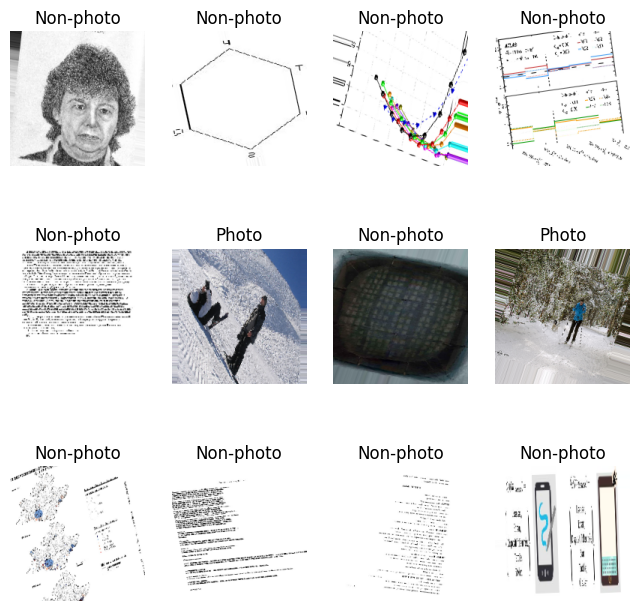

In [21]:
plt.figure(figsize = (8,8))
images, labels = next(train_set)

for i in range(12):
    ax=plt.subplot(3,4, i+1)
    plt.imshow(images[i])
    plt.title(class_names[int(labels[i])])
    plt.axis("off")

plt.show()

__Step 4: Building training environment__

This step involves building a CNN model architecture that begins with an input pipeline that applies data augmentation that introduces controlled random transformations such as rotations, zooms and horizontal flips to the training images. _This step artificially increases the diversity of the dataset and helps the model generalize better by reducing overfitting, especially when the dataset is limited or imbalanced._

Then normalization by rescaling pixel values to a [0,1] range.

The core of the model is composed of multiple convolutional layers followed by max-pooling layers. 

A brief explanation on the model:

    1. Convolutional layers apply learnable filters to extract visual features from the images, progressing from simple patterns (edges, textures) to more complex representations.

    2. Max-pooling layers downsample the feature maps, reducing spatial dimensions, lowering computational cost, and providing robustness to small spatial variations.

    3. A global average pooling layer compresses each feature map into a single value, reducing the number of parameters and helping prevent overfitting.

    4. A dense (fully connected) layer with ReLU activation learns non-linear combinations of the extracted features.

    5. The final dense layer uses a sigmoid activation to output a probability for binary classification, enabling clear and interpretable predictions.



In [22]:
#CNN Model Architecture
num_classes = 2
model = Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(image_h, image_w, 3)),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    #layers.Flatten(),
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

model.summary()

/home/dministrator-drew/projects/cesi/Data Science Option/.venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 178, 178, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 89, 89, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 87, 87, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 43, 43, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 41, 41, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 109,889 (429.25 KB)

 Trainable params: 109,889 (429.25 KB)

 Non-trainable params: 0 (0.00 B)

In [23]:
model.compile(
    optimizer = 'adam',
    loss = 'binary_crossentropy',
    metrics = ['accuracy']
)

In [24]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 178, 178, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 89, 89, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 87, 87, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 43, 43, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 41, 41, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 109,889 (429.25 KB)

 Trainable params: 109,889 (429.25 KB)

 Non-trainable params: 0 (0.00 B)

__Step 5: Training and Evaluation__


In [25]:
epochs = 4
history = model.fit(
    train_set,
    validation_data = test_set,
    epochs = epochs,
    verbose = 1
)

#history visualization
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(epochs_range, acc, label='Training accuracy')
plt.plot(epochs_range, val_acc, label='Validation accuracy')
plt.legend(loc='lower right')
plt.title('Training and validation accuracy')

plt.subplot(1,2,2)
plt.plot(epochs_range, loss, label='Training loss')
plt.plot(epochs_range, val_loss, label='Validation loss')
plt.legend(loc='upper right')
plt.title('Training and validation loss')

plt.show()

Epoch 1/4
 16/978 ━━━━━━━━━━━━━━━━━━━━ 8:30 531ms/step - accuracy: 0.6383 - loss: 0.6065

KeyboardInterrupt: 

From the graph above, it seems like our model is greatly overfitting because the training accuracy is really high and the loss is quite low. Also, with the training graphs havings spikes at moments might mean that there is a bit of noise in the test sets.

__Step 5. Finetuning and dealing with imbalances.__

Within this step, we use techniques designed to reduce the overlearning seen above. We have already augmented the dataset through _ImageDataGenerator_ so we shall use the following techniques for regularization and fine-tuning.

    1. Dropout technique - Randomly deactivating the neurons of a dense layer of the network at each processing step. Thus, a different sub-network is trained with each training batch. 
    

In [26]:
#building model with dropout
model_with_dropout = Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(image_h, image_w, 3)),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.5),
    #layers.Flatten(),
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

model_with_dropout.compile(
    optimizer = 'adam',
    loss = 'binary_crossentropy',
    metrics = ['accuracy']
)

model_with_dropout.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 178, 178, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 89, 89, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 87, 87, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 43, 43, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 41, 41, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 109,889 (429.25 KB)

 Trainable params: 109,889 (429.25 KB)

 Non-trainable params: 0 (0.00 B)

In [27]:
epochs = 7
history = model_with_dropout.fit(
    train_set,
    validation_data = test_set,
    epochs = epochs,
    verbose = 1
)

#history visualization
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(epochs_range, acc, label='Training accuracy')
plt.plot(epochs_range, val_acc, label='Validation accuracy')
plt.legend(loc='lower right')
plt.title('Training and validation accuracy')

plt.subplot(1,2,2)
plt.plot(epochs_range, loss, label='Training loss')
plt.plot(epochs_range, val_loss, label='Validation loss')
plt.legend(loc='upper right')
plt.title('Training and validation loss')

plt.show()

Epoch 1/7
 10/978 ━━━━━━━━━━━━━━━━━━━━ 10:56 678ms/step - accuracy: 0.6995 - loss: 0.5934

KeyboardInterrupt: 